In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
np.set_printoptions(suppress = True)

# 第十二章

## 零、练一练

```{admonition} 练一练
在阅读归一化方法的内容后，思考以下问题：
- 上述案例中只在单侧添加了极端值，对于双侧都含有极端值的分布如何将其合理变换至$[0,1]$区间？
- 如何修改上文归一至$[−1,1]$区间的方法，使其归一化不易受极端值影响？
```

- 1

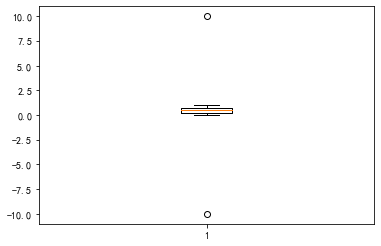

In [2]:
s = pd.Series([-10] + list(np.random.rand(1000)) + [10])
_ = plt.boxplot(s)

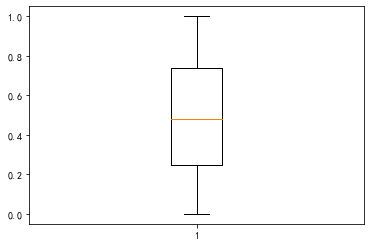

In [3]:
s_fix = s.clip((-s).nlargest(2).iloc[1], s.nlargest(2).iloc[1])
_ = plt.boxplot(s_fix)

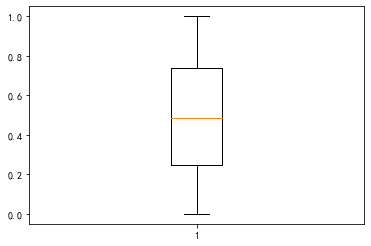

In [4]:
# 还可以通过异常检测来做，预测为异常的离群点进行剔除
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)
label = clf.fit_predict(s.values[:, None])
s_fix2 = s[label==1]
_ = plt.boxplot(s_fix2)

- 2

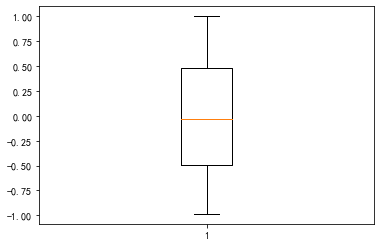

In [5]:
# 直接用上面的去除异常后再操作
new_data = s_fix - s_fix.mean()
new_data = new_data / new_data.abs().max()
_ = plt.boxplot(new_data)

```{admonition} 练一练
阅读上述关于上凸变换的内容，完成以下任务：
- 请模仿图12.5对土地面积进行类似绘制。
- 当对数变换的底数变化时，新数据的偏度会变化吗？为什么？
- 请构造1个上凸变换并将其应用于人口的特征列使其偏度尽可能接近0。
- 在自变量$x$非负时，幂变换$x\rightarrow x^\lambda$在$\lambda$取何值为下凸变换（二阶导数恒大于0）？它一定是关于自变量的单调递增变换吗？
- 鉴于上凸变换能够将右偏分布的偏度减小，那么也就不难想到下凸变换能够提高左偏分布的偏度，请构造1个相应的例子来说明。（偏态分布可以选择从scipy.stats.skewnorm.rvs中生成）
```

- 1

```python
df = pd.read_csv("data/ch12/area-pop.csv")
my_lambda = np.linspace(1e-4, 1e0, 100)
skew = [(df.LandArea ** i).skew() for i in my_lambda]
plt.plot(my_lambda, skew)
plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("Skewness of Land Area")
```

- 2

由于对随机变量进行数乘不会改变偏度（参见偏度公式易得），且$Skew[\log_a(X)] = Skew[\frac{\log_b(X)}{\log_b(a)}]=Skew[\log_b(X)]$，因此不变。

- 3

观察到$\lambda$与偏度是单调关系，因此考虑使用二分法：

In [6]:
df = pd.read_csv("data/ch12/area-pop.csv")
left, right = 0.1, 1
while right - left > 1e-15:
    mid = (left + right) / 2
    mid_skew = (df.Population ** mid).skew()
    if mid_skew > 0:
        right = mid
    else:
        left = mid
mid

0.42813584913391733

因此可取$x\rightarrow x^{0.428}$

- 4

当$\lambda\in (-\infty, 0)\cup(1,\infty)$时为下凸变换，且当取大于1的部分时关于自变量单调递增。

- 5

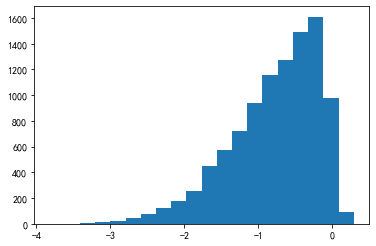

In [7]:
from scipy.stats import skewnorm
arr = skewnorm.rvs(-10, size=10000)
_ = plt.hist(arr, bins=20)

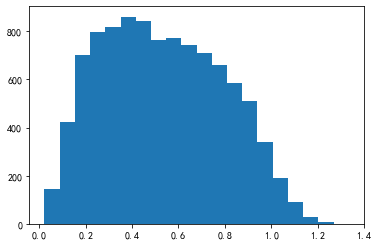

In [8]:
from scipy.stats import skewnorm
arr_transformed = np.exp(arr)
_ = plt.hist(arr_transformed, bins=20)

In [9]:
pd.Series(arr).skew(), pd.Series(arr_transformed).skew()

(-0.9270804770609488, 0.20833973262593455)

```{admonition} 练一练
scipy中的stats模块封装了许多与分布有关的生成函数，通过from scipy import stats导入后，对于不同的c值，stats.loggamma.rvs(c, size=500)能够产生不同偏态的对数伽马分布。请利用这个函数构造一些实数区间上的偏态分布，分别使用Box-Cox方法和Yeo-Johnson方法（处理含负值的数据）来进行数据变换，并观察变换前后的数据分布变化情况以及偏度变化。
```

1.3973251898008774

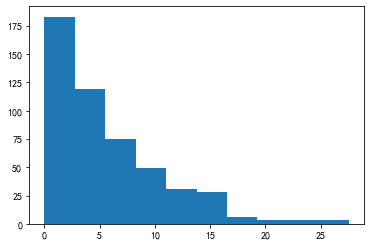

In [10]:
from scipy.stats import loggamma
arr = np.abs(-loggamma.rvs(0.2, size=500))
_ = plt.hist(arr)
pd.Series(arr).skew()

-0.05967809812317035

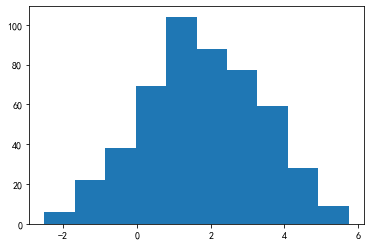

In [11]:
from scipy.stats import boxcox
arr_boxcox, Lambda = boxcox(arr)
_ = plt.hist(arr_boxcox)
pd.Series(arr_boxcox).skew()

-0.008792036144633997

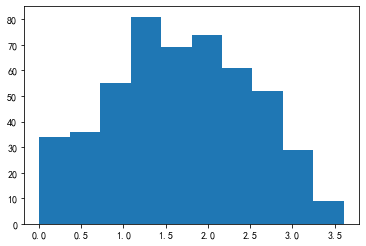

In [12]:
from scipy.stats import yeojohnson
arr_yeojohnson, Lambda = yeojohnson(arr)
_ = plt.hist(arr_yeojohnson)
pd.Series(arr_yeojohnson).skew()

-1.891705548089777

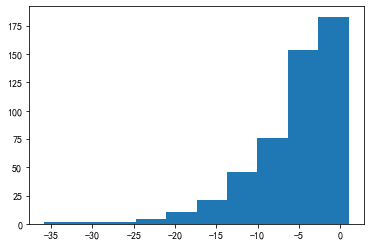

In [13]:
from scipy.stats import loggamma
arr_neg = loggamma.rvs(0.2, size=500)
_ = plt.hist(arr_neg)
pd.Series(arr_neg).skew()

-0.00037076210222004364

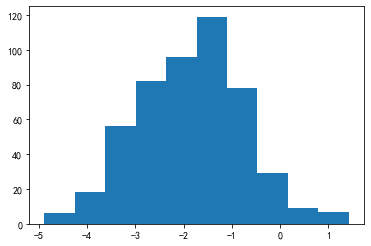

In [14]:
from scipy.stats import yeojohnson
arr_neg_yeojohnson, Lambda = yeojohnson(arr_neg)
_ = plt.hist(arr_neg_yeojohnson)
pd.Series(arr_neg_yeojohnson).skew()

```{admonition} 练一练
在data/ch12/passage_ch文件夹下包含了若干篇中文文档，结合jieba分词工具和sklearn中的tf-idf计算模块，提取每篇文章的主题特征。（提示：在TfidfVectorizer构造器中指定tokenizer参数为jieba.cut）
```

In [15]:
from sklearn.feature_extraction.text import (
    TfidfVectorizer, TfidfTransformer)
import jieba
passages = []
for i in range(1,21):
    with open("data/ch12/passage_ch/%d.txt"%i, encoding="utf8") as f:
        passage = " ".join(f.readlines())
        passages.append(passage)
vectorizer = TfidfVectorizer(tokenizer=jieba.cut)
count = vectorizer.fit_transform(passages)
transformer = TfidfTransformer()
result = transformer.fit_transform(count)
np.array(vectorizer.get_feature_names_out())[result.toarray().argmax(1)]

Building prefix dict from the default dictionary ...


Loading model from cache C:\Users\gyh\AppData\Local\Temp\jieba.cache


Loading model cost 0.633 seconds.


Prefix dict has been built successfully.


array(['地震', '代谢', '王安石', '素描', '函数', '计算机', '微积分', '上海', '奥运会', '哈佛',
       '味道', '鳄鱼', '冥王星', '麦克斯韦', '雕塑', '智商', '鲨鱼', '冰壶', '钢琴', '高斯'],
      dtype=object)

```{admonition} 练一练
请封装一个函数best_ks()，其输入参数为需要分箱的Series、目标变量的Series、分箱的个数，输出结果为best-ks分箱的结果Series，每个元素值为原序列对应元素所属的箱子（Interval）。此处规定，当箱子中只有一个类别或只有一个元素时则不进行分箱，因此最终箱子的个数可能与给定的分箱个数可能不同。
```

In [16]:
import bisect
def best_ks(s, y, n):
    bin_left, bin_right = s.min(), s.max()+0.001
    cut_points = [bin_left, bin_right]
    def _helper_find(s, y):
        data_sorted = pd.DataFrame({"s":s, "y":y}).sort_values("s")
        y_0 = (data_sorted.y==0).cumsum()/(data_sorted.y==0).sum()
        y_1 = (data_sorted.y==1).cumsum()/(data_sorted.y==1).sum()
        cut_point = data_sorted.iloc[(y_1 - y_0).abs().argmax()]["s"]
        return cut_point
    def _helper_bin(s, y, left, right, n):
        if y.all() or (1-y).all(): # 只有一个类别了
            return
        if y.shape[0] <= 1: # 只有一个元素了
            return
        if n <= 0:
            return
        cut_point = _helper_find(s, y)
        bisect.insort(cut_points, cut_point) # 插入有序数组
        bool_left = (s>=left) & (s<cut_point)
        bool_right = (s>=cut_point) & (s<bin_right)
        _helper_bin(s[bool_left], y[bool_left], left, cut_point, n-1)
        _helper_bin(s[bool_right], y[bool_right], right, cut_point, n-1)
    _helper_bin(s, y, bin_left, bin_right, np.log2(n))
    return pd.cut(s, bins=cut_points, right=False, duplicates="drop")
s = pd.Series(np.random.uniform(0,100,1000))
y = pd.Series(np.random.randint(0,2,1000))
res = best_ks(s, y, 4)
res.head()

0     [8.859, 50.996)
1     [8.859, 50.996)
2    [73.897, 99.967)
3      [0.104, 8.859)
4     [8.859, 50.996)
dtype: category
Categories (4, interval[float64, left]): [[0.104, 8.859) < [8.859, 50.996) < [50.996, 73.897) < [73.897, 99.967)]

```{admonition} 练一练
请模拟生成1个时序Series，对上文提及的所有时间戳特征与时间差特征进行构造。
```

In [17]:
s = pd.Series(pd.date_range("20200101", "20211231"))
# 是否为双休日
res = s.dt.dayofweek.isin([5,6])
# 是否处于节假日
holiday = pd.date_range("20201001", "20201007")
res = s.isin(holiday)
# 是否处于月初或月末
res = s.dt.is_month_start
res = s.dt.is_month_end
# 是否处于白天或夜晚
res = s.dt.hour.between(8, 18)
# 是否处于特定时间段（如早上八点至十点或每月第一周的周末）
res = s.dt.hour.between(8, 10) | (s.dt.day_of_week.isin([5,6]) & (s.dt.day<=7))
# 样本所处月的工作天数
idx = pd.bdate_range("20200101", "20201231")
count = idx.to_series().dt.month.value_counts().reset_index()
count = count.rename(columns={"index":"month"})
temp = pd.Series(s.dt.month).to_frame().rename(columns={0:"month"})
res = temp.merge(count, on="month", how="left").rename(columns={0:"val"})
res = res.val
res.index = s.values
# 样本所处日期的年/月/日/小时/分钟/星期
res = s.dt.year
res = s.dt.month
res = s.dt.day
res = s.dt.hour
res = s.dt.second
res = s.dt.dayofweek
# k分钟/小时/天/前时间戳对应的元素值和当前时间戳对应的元素值的差
s_val = pd.Series(np.random.rand(s.shape[0]), index=s)
res = s_val.shift(freq="3D") - s_val

In [18]:
s = pd.Series(pd.timedelta_range("0s", "10000000s", freq="4min 30s"))
res = s.dt.days # 天数
res = s.dt.total_seconds() // 60 # 分钟数
res = s.dt.total_seconds() # 总秒数
res = s.dt.seconds # 对天数取余的秒数

```{admonition} 练一练
阅读上述WoE的材料，完成以下问题：
- 在WoE的计算中，如果某个组内没有负样本时会导致分母为0，而没有正样本会导致$\log$函数的输入值非法，请设计1种方案来处理这2类情况。
- 请构造1个序列及其标签$y$，分别使用best-ks分箱和节点分箱2种策略得到序列的WoE特征。
- 对于不同的分箱策略而言，我们可以通过计算信息值（Information Value）$IV=\sum_i (\frac{P^i}{P^T}-\frac{N^i}{N^T})*WoE_i$的大小来比较分箱方案的优劣，请对第（2）问中的分箱结果进行比较。一般而言，当IV值超过0.1时，可认为分箱策略是有意义的，当超过0.3时表示分箱效果较好，得分越高则效果越显著。
```

- 1

可将计算公式调整为

$$
WoE_i=\log[\frac{(P^i+1)/(N^i+1)}{(P^T+1)/(N^T+1)}]
$$

- 2

(-1.0, 1.0)

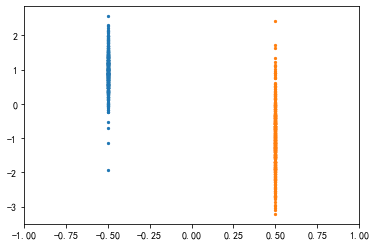

In [19]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1000, n_features=1,
    n_informative=1, n_redundant=0,
    n_classes=2, n_clusters_per_class=1,
    random_state=2
)
s, y = pd.Series(X[:, 0]), pd.Series(y) # 
plt.scatter([-0.5]*int(sum(y==1)), X[y==1, 0], s=5)
plt.scatter([0.5]*int(sum(y==0)), X[y==0, 0], s=5)
plt.xlim(-1, 1)

In [20]:
from sklearn.tree import DecisionTreeClassifier
def node_cut(s, y):
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(s.values.reshape(-1,1), y)
    cut_edge = pd.Series(model.tree_.threshold).drop_duplicates().sort_values()
    bins = cut_edge.tolist() + [np.inf]
    bins[0] = -np.inf
    return pd.cut(s, bins=bins, right=False, duplicates="drop")

In [21]:
res_ks = best_ks(s, y, 4)
res_node = node_cut(s, y)
f = lambda x: ((x==1).mean()/(x==0).mean())
WoE_ks = np.log(y.groupby(res_ks).agg(f)/f(y))
WoE_node = np.log(y.groupby(res_node).agg(f)/f(y))

In [22]:
WoE_ks

[-3.208, -0.251)   -4.638729
[-0.251, 0.183)    -0.610136
[0.183, 0.605)      1.298913
[0.605, 2.557)      3.048428
dtype: float64

In [23]:
WoE_node

[-inf, -0.239)    -4.641153
[-0.239, 0.109)   -0.781705
[0.109, 0.347)     0.296105
[0.347, inf)       2.744596
dtype: float64

- 3

In [24]:
Pt, Nt = (y==1).shape[0], (y==0).shape[0]
IV_ks = 0
for idx in WoE_ks.index:
    bool_s = res_ks == idx
    WoE = WoE_ks[idx]
    IV_ks += (
        y[bool_s & (y==1)].shape[0] / Pt 
        - y[bool_s & (y==0)].shape[0] / Nt
    ) * WoE
IV_ks

3.098410522709232

In [25]:
IV_node = 0
for idx in WoE_node.index:
    bool_s = res_node == idx
    WoE = WoE_node[idx]
    IV_ks += (
        y[bool_s & (y==1)].shape[0] / Pt 
        - y[bool_s & (y==0)].shape[0] / Nt
    ) * WoE
IV_ks

6.178057847331045

```{admonition} 练一练
请对城市面积和人口数据集（即data/ch12/area-pop.csv）中的两个特征进行对数变换和标准化变换后降维，选取第一个主成分。
```

In [26]:
from sklearn.decomposition import PCA
df = pd.read_csv("data/ch12/area-pop.csv")
df = df.apply(lambda x: np.log(x))
df = df.apply(lambda x: (x-x.mean())/x.std())
pca = PCA(n_components=1) # 取第一主成分
new_feature = pca.fit_transform(df.values)
new_feature.shape # 降维特征的维度

(120, 1)

```{admonition} 练一练
请根据上述的检验思想和代码完成以下问题：
- 将$2\times 2$的卡方检验推广至$r\times c$。同时，给出特征重要性选择函数chi2\_choose()的构造，它接收的参数为2维的离散特征数组$X$和1维的目标数组$y$，输出值为这些特征的$p$值排名。统计量的计算可参考第一章习题二，也可直接使用chi2\_contingency()。
- 虽然连续型的特征和目标变量无法直接进行卡方检验，但是可以将特征和目标进行分箱从而转化为类别，请利用这个想法对df_reg的特征$f_1$关于$y$进行卡方检验。
```

- 1

In [27]:
from scipy.stats import chi2_contingency
np.random.seed(0)
X = pd.DataFrame(
    {
        "A": np.random.randint(0, 6, 1000),
        "B": np.random.randint(0, 4, 1000),
        "C": np.random.randint(0, 10, 1000),
    }
)
y = np.random.randint(0, 4, 1000)
def chi2_choose(X, y):
    ps = []
    for arr in X.values.T:
        _, p = chi2_contingency(pd.crosstab(arr, y))[:2]
        ps.append(p)
    return pd.DataFrame(
        {
            "Cols": X.columns,
            "Rank": pd.Series(ps).rank().values.astype("int")
        }
    )
chi2_choose(X, y)

,Cols,Rank
0,A,1
1,B,3
2,C,2


- 2

In [28]:
X = pd.DataFrame(
    {
        "A": np.random.rand(1000),
        "B": np.random.rand(1000),
        "C": np.random.rand(1000),
    }
)
y = np.random.rand(1000)
def chi2_choose_continuous(X, y):
    ps = []
    y = pd.cut(pd.Series(y), bins=5)
    for arr in X.values.T:
        arr = pd.cut(pd.Series(arr), bins=5)
        _, p = chi2_contingency(pd.crosstab(arr, y))[:2]
        ps.append(p)
    return pd.DataFrame(
        {
            "Cols": X.columns,
            "Rank": pd.Series(ps).rank().values.astype("int")
        }
    )
chi2_choose_continuous(X, y)

,Cols,Rank
0,A,2
1,B,1
2,C,3


```{admonition} 练一练
请构造1个3分类的数据集（在make_classification()中指定n_classes为3），选取其中的1个变量进行F检验，再调用f_classif核对是否与其输出结果一致。
```

In [29]:
from sklearn.datasets import make_classification
cls_X, cls_y = make_classification(n_samples=1000, n_features=10,
    n_informative=3, n_classes=3, random_state=0)
df_cls = pd.DataFrame(np.c_[cls_X, cls_y],
    columns=["f%d"%i for i in range(1, 11)]+["y"])

In [30]:
group = df_cls[["f1", "y"]].groupby("y")
W = ((group.mean() - df_cls["f1"].mean())**2 * group.count()).sum()["f1"]
E = (group.var() * (group.count()-1) ).sum()["f1"]
F = (W/(3-1)) / (E/(df_cls.shape[0]-3))
F

1.014934961909982

In [31]:
from scipy.stats import f as f_distribution
f_distribution.sf(F, 2, df_cls.shape[0]-3)

0.3628001419102242

In [32]:
from sklearn.feature_selection import f_classif
F, p = f_classif(df_cls.values[:, [0]], df_cls.y)
F, p

(array([1.01493496]), array([0.36280014]))

```{admonition} 练一练
sklearn中svm模块下的分类模型LinearSVC也支持使用$L_1$正则化来训练模型，请阅读相应的官方文档页面并仿照上述LASSO或逻辑回归的例子，对df_cls数据集进行变量选择。（提示：参考文档并尝试调节SelectFromModel的threshold参数）
```

In [33]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
cls_X, cls_y = make_classification(n_samples=10000, n_features=10,
    n_informative=3, n_classes=2, random_state=1)
df_cls = pd.DataFrame(np.c_[cls_X, cls_y],
    columns=["f%d"%i for i in range(1, 11)]+["y"])
model_cls = LinearSVC(penalty="l1", dual=False, random_state=0)
model_cls = model_cls.fit(df_cls.iloc[:,:-1], df_cls.y)
model = SelectFromModel(model_cls, prefit=True, threshold=0.2)
X_cls_new = model.transform(df_cls.iloc[:,:-1].values)
X_cls_new.shape

(10000, 3)

```{admonition} 练一练
如何修改上述代码以合理估计未被剔除列的特征重要性排名（需要考虑hit数相同时特征重要性的比较）？
```

只需计算每个特征平均每轮的1-p_accept（当p_accept小表示接收概率大）后排序即可：

In [34]:
from sklearn.datasets import make_regression
reg_X, reg_y = make_regression(n_samples=10000, n_features=10,
    n_informative=3, n_targets=1, random_state=1)
df_reg = pd.DataFrame(np.c_[reg_X, reg_y],
    columns=["f%d"%i for i in range(1, 11)]+["y"])

In [35]:
from scipy.stats import binom
from sklearn.ensemble import GradientBoostingRegressor
alpha, max_iter = 0.1, 10
model = GradientBoostingRegressor(
    n_estimators=50, max_depth=5, random_state=0)
status = np.zeros(df_reg.shape[1]-1)
hit = np.zeros(df_reg.shape[1]-1)
ps = np.zeros(df_reg.shape[1]-1)
counts = np.zeros(df_reg.shape[1]-1)
cur_iter = 1
while (status==0).any() and cur_iter <= max_iter:
    df_shuffled = df_reg.iloc[:,:-1].apply(np.random.permutation) 
    df_shuffled.columns = ["sf_f%d"%m for m in range(1,11)]
    df_concat = pd.concat([df_reg.iloc[:,:-1], df_shuffled], axis=1) 
    model.fit(df_concat, df_reg.iloc[:, -1])
    fi = model.feature_importances_
    original_importance = fi[:df_reg.shape[1]-1]
    shuffled_importance = fi[df_reg.shape[1]-1:]
    F_max = shuffled_importance.max()
    for i in range(df_reg.shape[1]-1):
        if original_importance[i] > F_max:
            hit[i] += 1
        if status[i] != 0:
            continue
        p_accept = binom.cdf(cur_iter - hit[i], cur_iter, 0.5)
        p_reject = binom.cdf(hit[i], cur_iter, 0.5)
        # 为什么需要判断？前面几轮实际上还不稳定，得出的概率值方差很大
        if cur_iter > 5:
            ps[i] += 1 - p_accept
            counts[i] += 1
        threshold = alpha / (df_reg.shape[1]-1)
        if p_accept <= threshold:
            status[i] = 1
        elif p_reject <= threshold:
            status[i] = -1
    cur_iter += 1
proba = ps / counts
res = pd.DataFrame({
    "Column": df_cls.columns[:-1],
    "Rank": pd.Series(proba).rank(ascending=False, method="first").values.astype("int"),
    "Proba of Accept": proba
})
res

,Column,Rank,Proba of Accept
0,f1,5,0.771875
1,f2,4,0.907813
2,f3,8,0.000000
3,f4,7,0.020313
4,f5,1,0.988281
5,f6,9,0.000000
6,f7,2,0.988281
7,f8,3,0.988281
8,f9,6,0.673438
9,f10,10,0.000000


## 一、卡方分箱


卡方分箱是一种利用卡方值来分箱的方法，其核心思想是：对于2个相邻的箱子（实际表示区间），如果目标$y$和箱子所属编号（即按照属于左边的箱子还是右边的箱子划分类别）之间的卡方值较小，说明这2个箱子的边界划分无法有效区分目标$y$的情况，因此需要对这2个箱子进行合并。其分箱流程为：事先指定最大分箱数量$Bin_{max}$、最小分箱数量$Bin_{min}$和阈值$\chi_0^2$，首先对数据按照最大分箱数量进行qcut得到$Bin_{max}$个箱子，接着每一轮计算所有2个相邻箱子（特征需要排序）的卡方值，合并这一轮中卡方值最小的1组相邻箱子，算法终止条件为某一轮剩余的箱子个数达到了最小分箱数量$Bin_{min}$或者所有相邻箱子的卡方值都高于给定的阈值$\chi_0^2$。sklearn内置的鸢尾花数据集是一个3分类任务的数据集，请根据上述卡方分箱的原理对于“sepal length (cm)”列进行分箱。

In [36]:
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.iloc[:,[0,-1]].head()

,sepal length (cm),target
0,5.1,0
1,4.9,0
2,4.7,0
3,4.6,0
4,5.0,0


```text
【解答】
```

In [37]:
def get_chi2(s, y, bins):
    y1 = y[(s>=bins[0])&(s<bins[1])]
    y2 = y[(s>=bins[1])&(s<bins[2])]
    a = np.r_[y1.values, y2.values]
    b = np.r_[[0] * len(y1), [1] * len(y2)]
    return chi2_contingency(pd.crosstab(a, b))[0]

def chi2_cut(s, y, max_nbins, min_nbins, chi2_0):
    bins = pd.cut(s, bins=max_nbins).cat.categories.to_tuples()
    bins = [bins[i][0] for i in range(len(bins))] + [bins[-1][-1]]
    cur_bins, cur_chi2 = max_nbins, -np.inf
    while cur_bins > min_nbins and cur_chi2 <= chi2_0:
        merge_i = 1
        min_chi2 = np.inf
        for i in range(1, len(bins)-1):
            adj_bin = bins[i-1:i+2]
            chi2 = get_chi2(s, y, adj_bin)
            if chi2 < min_chi2:
                merge_i = i
                min_chi2 = chi2
        cur_chi2 = min_chi2
        bins.pop(merge_i)
        cur_bins -= 1
    return bins

s, y = df["sepal length (cm)"], df["target"]
chi2_cut(s, y, 10, 4, 3.5) # 返回箱子边界

[4.296, 5.38, 5.74, 6.1, 7.9]

## 二、基于标签的特征构造

本章中大多介绍的特征构造方法都是无监督方式，即不利用任何$y$中的信息来构造特征，而本章中介绍的分箱方法都是有监督方法，它们利用了$y$的信息来进行分箱的节点切割。事实上，还有很多其他利用标签的特征构造方法，请读者阅读如下的2种构建思路并完成相应任务。

- 伪标签方法是一种半监督学习方法，它将一部分可信的标签作为真实样本参与模型训练。例如对于二分类问题，许多模型都可以输出$y=1$或$y=0$的概率，当某一些测试样本输出的预测概率很高时，说明模型很有把握其被归为某一个类别，此时我们可以直接将这些样本赋予伪标签，即当$y=1$的概率为0.9998时，直接将其视为$y=1$，重新训练模型。请利用上题中提到的鸢尾花数据集，使用逻辑回归模型进行基于伪标签方法的预测。sklearn中逻辑回归的使用方法在下面的代码块中给出。

In [38]:
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
model = LogisticRegression(max_iter=150, random_state=0).fit(X, y)
model.predict(X[:2, :]) # 前2个样本的预测类别

array([0, 0])

In [39]:
model.predict_proba(X[:2, :]) # 前2个样本属于每个类别的概率

array([[0.98158201, 0.01841798, 0.00000001],
       [0.9713355 , 0.02866447, 0.00000003]])

- 在回归问题中，模型预测值与真实标签值的残差有时也能作为重要特征，例如某些模型在不同的特征集合上会对真实值存在高估、低估或某种模式的有偏估计，此时可以加入残差特征来获得这种模式的信息。事实上，虽然在训练集上能够获得残差，但是在测试集上由于标签未知，我们无法知道真实的残差值，此时可以使用2阶段的方式进行模型训练。在第一阶段中，在训练集上使用模型$A$来拟合特征$X$和真实标签$y$，把该模型$A$的样本预测结果记作$\hat{y}$，将残差记作$e=y-\hat{y}$。在第二阶段中，在训练集上使用模型$B$来拟合特征$X$和残差$e$。在测试集上，我们把特征$x_{test}$输入模型$A$得到$\hat{y}_{test}$，再把特征$x_{test}$输入模型$B$得到$\hat{e}_{test}$，最后把$\hat{y}_{test}$和$\hat{e}_{test}$相加得到正式的预测输出。由于2个模型的输入部分只用了特征本身而不涉及真实标签，因此整个流程是可训练的并且利用到了残差的信息。请使用sklearn中的make\_regression()函数构造1个回归数据集，选择任意一个回归模型按照上述流程进行2阶段预测。

```text
【解答】
```

- 1

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)
model = LogisticRegression(max_iter=150, random_state=0).fit(X_train, y_train)
y_predict = model.predict(X_test)
acc1 = accuracy_score(y_test, y_predict) # 准确率
proba = model.predict_proba(X_test)
high_confidence = (proba > 0.8).any(1)
X_train_new = np.concatenate([X_train, X_test[high_confidence]])
y_train_new = np.concatenate([y_train, proba.argmax(1)[high_confidence]])
model_new = LogisticRegression(max_iter=150, random_state=0).fit(
    X_train_new, y_train_new)
y_predict = np.empty_like(y_test, dtype="int")
y_predict[high_confidence] = proba.argmax(1)[high_confidence]
y_predict[~high_confidence] = model_new.predict(X_test[~high_confidence])
acc2 = accuracy_score(y_test, y_predict) # 再次计算准确率
acc1, acc2

(0.9333333333333333, 0.9466666666666667)

- 2

In [41]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=10000, n_features=10,
    n_informative=3, n_targets=1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
model = DecisionTreeRegressor(max_depth=8, random_state=0)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
mean_squared_error(y_test, y_predict)

594.5708462639824

In [43]:
model_A = DecisionTreeRegressor(max_depth=8, random_state=0)
model_A.fit(X_train, y_train)
y_hat_train = model_A.predict(X_train)
e_train = y_train - y_hat_train
model_B = DecisionTreeRegressor(max_depth=8, random_state=0)
model_B.fit(X_train, e_train)
y_hat_test = model_A.predict(X_test)
e_hat_test = model_B.predict(X_test)
y_predict = y_hat_test + e_hat_test
mean_squared_error(y_test, y_predict)

511.7823781216827

## 三、信用卡诈骗数据的特征工程

信用卡消费已经成为当今大众生活的重要消费方式之一，但目前利用信用卡诈骗交易的非法事件也越来越多，这增加了用户、银行以及金融机构的风险，因此通过交易订单的特征来预测其是否为诈骗交易是金融风控中的重要任务。现有1个信用卡诈骗交易情况的数据集（data/ch12/creditcard.csv），其中包含了28个匿名特征，1个时间特征（Time列中的数字代表自2013年9月1日0点以来的秒数）、1个交易金额特征（Amount）以及1个目标特征（Class为1代表是诈骗交易），请按照下面的思路，结合本章所学知识逐步进行特征工程。

In [44]:
df = pd.read_csv("data/ch12/creditcard.csv")
df.iloc[:,[0,1,2,-3,-2,-1]].head()

,Time,V1,V2,V28,Amount,Class
0,0.0,-1.359807,-0.072781,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,0.061458,123.50,0
4,2.0,-1.158233,0.877737,0.215153,69.99,0


- 将Time列还原至时间戳序列。
- 基于分箱技术对特征进行变换。
- 通过Time列构造尽可能丰富的时序特征。
- 利用分组技术构造尽可能丰富的交叉特征。
- 对所有变量进行特征降维。
- 使用本章介绍的各类特征选择方法进行特征选择。

```text
【解答】
```

- 1

In [45]:
df = pd.read_csv("data/ch12/creditcard.csv")
df.Time = pd.to_timedelta(df.Time, unit="s") + pd.Timestamp("20130901")

- 2-6

略